In [ ]:
import os
import random
import numpy as np
import torch

SEED = 42  

# Python built-in RNG
random.seed(SEED)

# NumPy RNG
np.random.seed(SEED)

# PyTorch RNGs
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior (may slightly reduce performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: make hash-based ops deterministic
os.environ["PYTHONHASHSEED"] = str(SEED)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import pickle

# B-spline basis function
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else (t - Ln[i - 1]) / (Ln[d + i - 1] - Ln[i - 1])
        b = 0 if (Ln[d + i] - Ln[i]) == 0 else (Ln[d + i] - t) / (Ln[d + i] - Ln[i])
        return a * BsFun(i, d - 1, t, Ln) + b * BsFun(i + 1, d - 1, t, Ln)

# B-spline derivative basis function (first derivative)
def BsFun_derivative(i, d, t, Ln):
    if d == 0:
        return 0.0
    else:
        a = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else d / (Ln[d + i - 1] - Ln[i - 1])
        b = 0 if (Ln[d + i] - Ln[i]) == 0 else d / (Ln[d + i] - Ln[i])
        return a * BsFun(i, d - 1, t, Ln) - b * BsFun(i + 1, d - 1, t, Ln)

# Second derivative of B-spline
def BsFun_second_derivative(i, d, t, Ln):
    if d < 2:
        return 0.0
    else:
        a = 0 if (Ln[d + i - 2] - Ln[i - 2]) == 0 else d * (d - 1) / ((Ln[d + i - 2] - Ln[i - 2]) ** 2)
        b = 0 if (Ln[d + i - 1] - Ln[i - 1]) == 0 else 2 * d * (d - 1) / ((Ln[d + i - 1] - Ln[i - 1]) ** 2)
        c = 0 if (Ln[d + i] - Ln[i]) == 0 else d * (d - 1) / ((Ln[d + i] - Ln[i]) ** 2)
        return a * BsFun(i, d - 2, t, Ln) - b * BsFun(i + 1, d - 2, t, Ln) + c * BsFun(i + 2, d - 2, t, Ln)

# B-spline knots and basis matrix
def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)

    # Construct the knots vector
    for i in range(d + 1, n_knots - d - 1):
        Ln[i] = i - d
    Ln[n_knots - d - 1:] = n_cp - d  # The last d+1 elements should be the same

    # Parameter vector (linearly spaced)
    tk = np.zeros(Ns)
    for i in range(1, Ns):
        tk[i] = tk[i - 1] + Ln[-1] / (Ns - 1)

    # B-spline basis matrix
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j + 1, d, tk[i], Ln)

    Bit[Ns - 1, n_cp - 1] = 1
    return tk, Ln, Bit

# Compute B-spline basis matrix derivatives
def BsKnots_derivatives(n_cp, d, Ns, Ln, tk):
    # First derivative
    Bit_derivative = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_derivative[i, j] = BsFun_derivative(j + 1, d, tk[i], Ln)

    # Second derivative
    Bit_second_derivative = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_second_derivative[i, j] = BsFun_second_derivative(j + 1, d, tk[i], Ln)

    return Bit_derivative, Bit_second_derivative

# Compute derivatives of B-spline surfaces
def compute_bspline_derivatives(U_full, Bit_t, Bit_x, Bit_t_derivative, Bit_x_derivative):
    # First derivative with respect to time t (using first derivative of Bit_t)
    B_surface_t = torch.matmul(torch.matmul(Bit_t_derivative, U_full), Bit_x.T)

    # First derivative with respect to space x (using first derivative of Bit_x)
    B_surface_x = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_derivative.T)

    return B_surface_t, B_surface_x

Training Data - beta and phase change

In [ ]:
import numpy as np
import torch
import pickle
from tqdm import tqdm

# Constants for data generation
beta_range = (0.5, 1.5)  # Range of advection speeds
L_x = 1.0                # Length of the spatial domain
nx = 100                 # Number of spatial points
x = np.linspace(0, L_x, nx)  # Spatial grid

t_ini, t_fin = 0.0, 2.0  # Temporal domain
nt = 100                 # Number of temporal points
t = np.linspace(t_ini, t_fin, nt)  # Temporal grid

# We fix wave_number = 2*pi (one single wave),
# amplitude = 1, and random phase phi in [0, 2*pi).
# Then u0(x) = sin(2*pi*x + phi).

def initial_condition_sin_phase(x, phi):
    """
    Single-wave initial condition with random phase:
      u0(x) = sin(2*pi*x + phi)
    """
    return np.sin(2.0 * np.pi * x + phi)

def exact_solution_advection_phase(x, t, beta, phi):
    """
    Exact solution for pure advection with speed beta and random phase phi:
      u(t, x) = sin( 2*pi*( (x - beta*t) mod L_x ) + phi )
    """
    # Shift x by beta*t, apply modulo L_x
    x_shifted = (x - beta * t) % L_x
    return np.sin(2.0 * np.pi * x_shifted + phi)

# Generate training data
num_samples = 100  # Number of training samples
training_data = []

for _ in tqdm(range(num_samples), desc="Generating Training Data"):
    # Random beta in [0.8, 1.2]
    beta = np.random.uniform(*beta_range)

    # Random phase in [0, 2*pi)
    phi = np.random.uniform(0, 2.0 * np.pi)

    # wave_number = 2*pi, amplitude = 1
    wave_numbers_np = np.array([2.0 * np.pi], dtype=np.float32)
    amplitudes_np = np.array([1.0], dtype=np.float32)
    phases_np = np.array([phi], dtype=np.float32)

    # Build initial condition u0(x)
    u0 = initial_condition_sin_phase(x, phi)

    # Calculate the exact solution for all time steps
    U = np.zeros((nt, nx), dtype=np.float32)
    for j, tj in enumerate(t):
        U[j, :] = exact_solution_advection_phase(x, tj, beta, phi)

    # Store the data
    training_data.append({
        'beta': torch.tensor([[beta]], dtype=torch.float32),      # shape (1,1)
        'wave_numbers': torch.tensor(wave_numbers_np),            # shape (1,)
        'amplitudes': torch.tensor(amplitudes_np),                # shape (1,)
        'phases': torch.tensor(phases_np),                        # shape (1,)
        'x': torch.tensor(x, dtype=torch.float32),                # shape (nx,)
        't': torch.tensor(t, dtype=torch.float32),                # shape (nt,)
        'U': torch.tensor(U, dtype=torch.float32)                 # shape (nt, nx)
    })

# Save the training data
with open('advection_training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)

print("Data generation complete.")


Generating Training Data: 100%|██████████| 100/100 [00:00<00:00, 983.36it/s]

Data generation complete.


Testing Data

In [ ]:
import numpy as np
import torch
import pickle
from tqdm import tqdm

# Constants for data generation
beta_range = (0.5, 1.5)  # Range of advection speeds
L_x = 1.0                # Length of the spatial domain
nx = 100                 # Number of spatial points
x = np.linspace(0, L_x, nx)  # Spatial grid

t_ini, t_fin = 0.0, 2.0  # Temporal domain
nt = 100                 # Number of temporal points
t = np.linspace(t_ini, t_fin, nt)  # Temporal grid

# Single sine wave with random phase:
#   u0(x) = sin(2*pi*x + phi).
def initial_condition_sin_phase(x, phi):
    return np.sin(2.0 * np.pi * x + phi)

# Exact advection solution:
#   u(t,x) = sin(2*pi * ((x - beta*t) mod L_x) + phi)
def exact_solution_advection_phase(x, t, beta, phi):
    x_shifted = (x - beta * t) % L_x
    return np.sin(2.0 * np.pi * x_shifted + phi)

# Generate testing data
num_test_samples = 30  # Number of testing samples
testing_data = []

for _ in tqdm(range(num_test_samples), desc="Generating Testing Data"):
    # 1) Random advection speed in [0.8, 1.2]
    beta = np.random.uniform(*beta_range)
    # 2) Random phase in [0, 2*pi)
    phi = np.random.uniform(0, 2.0 * np.pi)

    # We fix wave_number=2*pi, amplitude=1
    wave_numbers_np = np.array([2.0 * np.pi], dtype=np.float32)
    amplitudes_np   = np.array([1.0],         dtype=np.float32)
    phases_np       = np.array([phi],         dtype=np.float32)

    # Build initial condition at x
    u0 = initial_condition_sin_phase(x, phi)  # shape (nx,)

    # Calculate the exact solution for all time steps
    U = np.zeros((nt, nx), dtype=np.float32)
    for j, tj in enumerate(t):
        U[j, :] = exact_solution_advection_phase(x, tj, beta, phi)

    # Store in the same structure used for training
    testing_data.append({
        'beta': torch.tensor([[beta]], dtype=torch.float32),    # shape (1,1)
        'wave_numbers': torch.tensor(wave_numbers_np),          # shape (1,)
        'amplitudes': torch.tensor(amplitudes_np),              # shape (1,)
        'phases': torch.tensor(phases_np),                      # shape (1,)
        'x': torch.tensor(x, dtype=torch.float32),              # shape (nx,)
        't': torch.tensor(t, dtype=torch.float32),              # shape (nt,)
        'U': torch.tensor(U, dtype=torch.float32)               # shape (nt, nx)
    })

# Save the testing data to a separate file
with open('advection_testing_data.pkl', 'wb') as f:
    pickle.dump(testing_data, f)

print("Testing data generation complete.")


Generating Testing Data: 100%|██████████| 30/30 [00:00<00:00, 995.62it/s]

Testing data generation complete.


Data Visualization

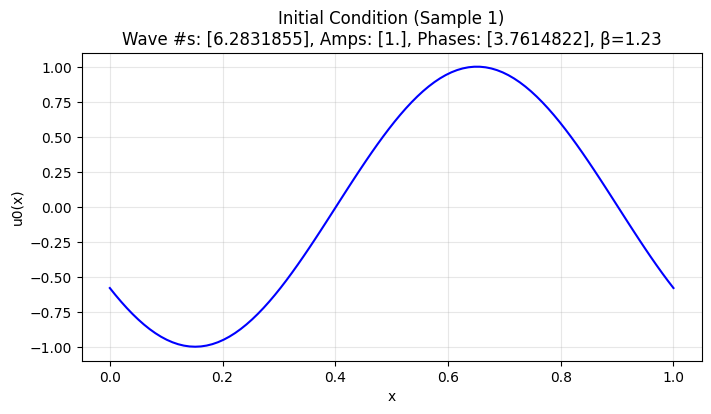

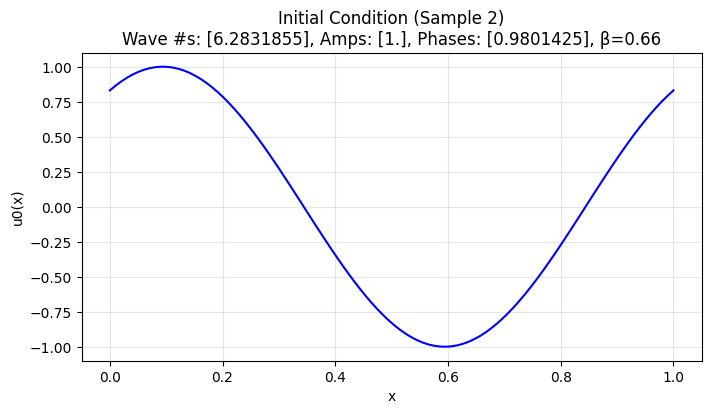

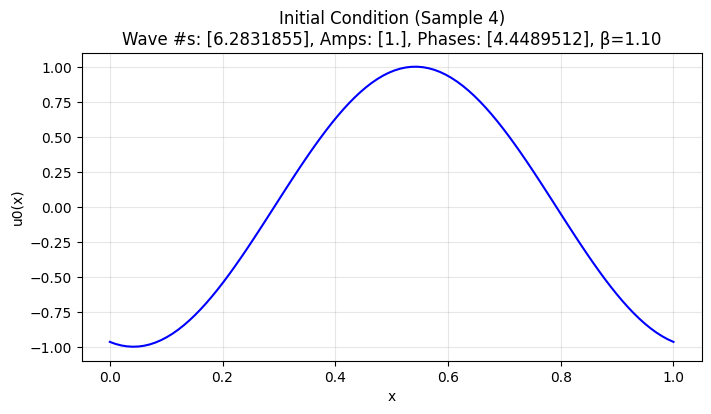

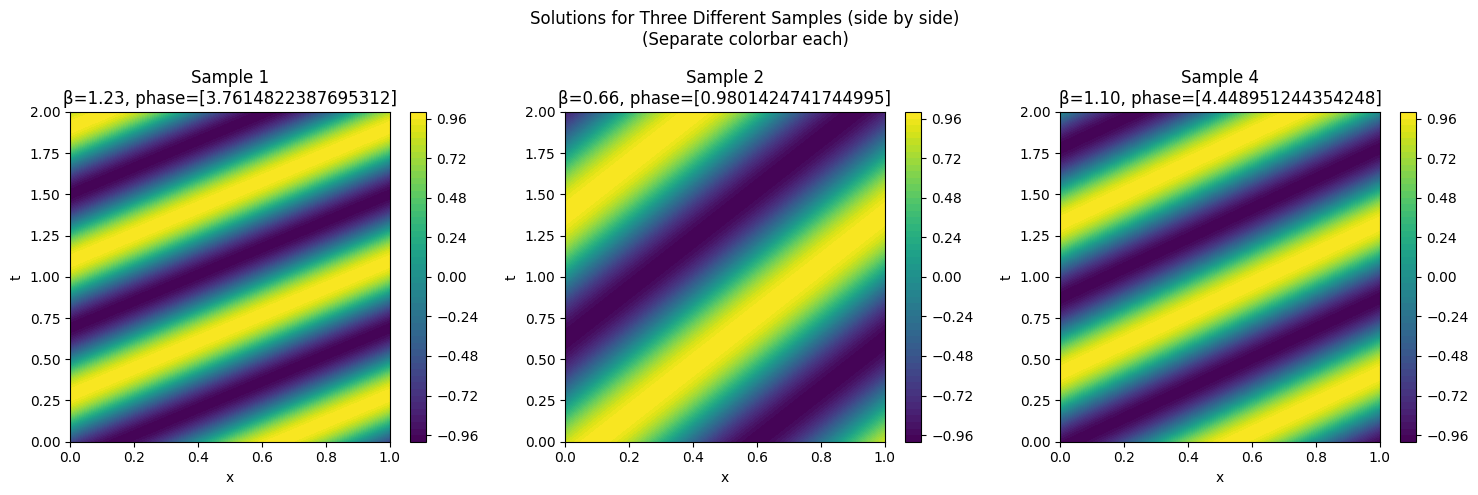

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 1. Load the training data
with open('advection_training_data.pkl', 'rb') as f:
    training_data = pickle.load(f)

# Choose three different samples to visualize
sample_indices = [1, 2, 4]  # Adjust to whichever samples you like

###############################################################
# A) Plot each sample's initial condition in separate figures
###############################################################
for idx in sample_indices:
    sample = training_data[idx]

    # Extract data
    x = sample['x'].numpy()                # Spatial grid (Nx,)
    U = sample['U'].numpy()                # (Nt, Nx)
    u0 = U[0, :]                            # Initial condition (Nx,)
    wave_numbers = sample['wave_numbers'].numpy()
    amplitudes  = sample['amplitudes'].numpy()
    phases      = sample['phases'].numpy()
    beta        = sample['beta'].item()

    # Plot the initial condition
    plt.figure(figsize=(8, 4))
    plt.plot(x, u0, color='blue')
    plt.title(f"Initial Condition (Sample {idx})\n"
              f"Wave #s: {wave_numbers}, Amps: {amplitudes}, Phases: {phases}, β={beta:.2f}")
    plt.xlabel("x")
    plt.ylabel("u0(x)")
    plt.grid(alpha=0.3)
    plt.show()

#######################################################################
# B) Show the solutions of all three samples side by side in one figure
#    Each subplot has its own colorbar, plus β and phase info in the title
#######################################################################
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    sample = training_data[idx]
    x = sample['x'].numpy()
    t = sample['t'].numpy()
    U = sample['U'].numpy()    # shape (Nt, Nx)

    # PDE parameters
    beta   = sample['beta'].item()
    phases = sample['phases'].numpy().tolist()

    # Create mesh for contour
    X, T = np.meshgrid(x, t)

    cs = axes[i].contourf(X, T, U, levels=50, cmap='viridis')
    # Separate colorbar for each subplot
    cbar = fig.colorbar(cs, ax=axes[i])

    # If your data contains multiple wave phases, we show them as a list
    axes[i].set_title(f"Sample {idx}\nβ={beta:.2f}, phase={phases}")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("t")

plt.suptitle("Solutions for Three Different Samples (side by side)\n(Separate colorbar each)")

plt.tight_layout()
plt.show()


LS Test

A shape: (100, 150), B shape: (100, 150), F shape: (100, 100)
Q_hat shape: (150, 150)
F_reconstructed shape: (100, 100)
Mean Reconstruction Error: 0.000002
Execution time: 2.0076 seconds


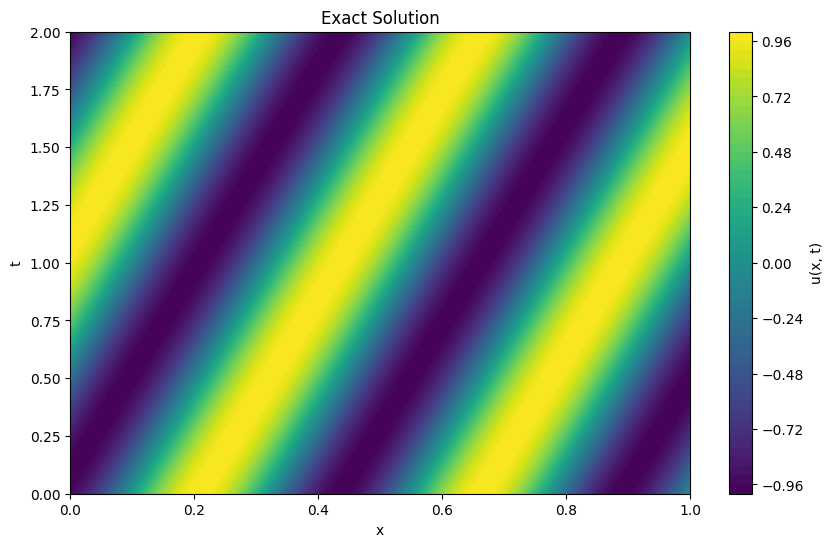

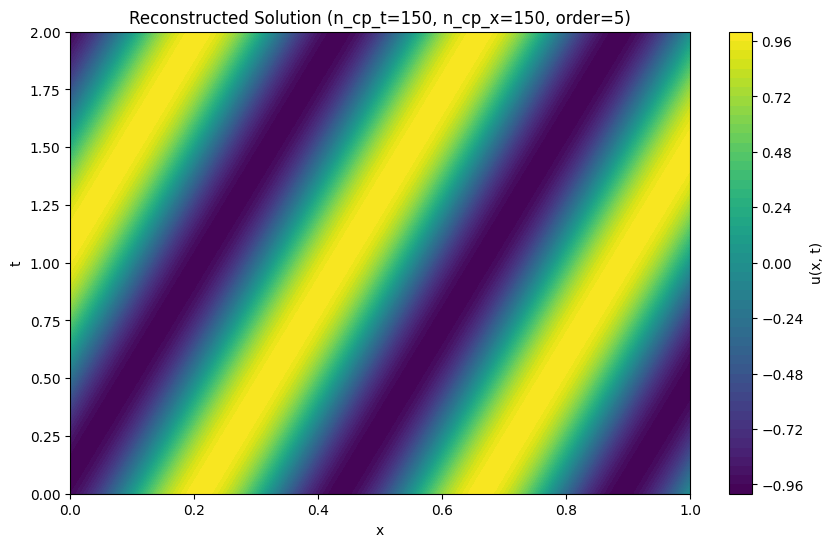

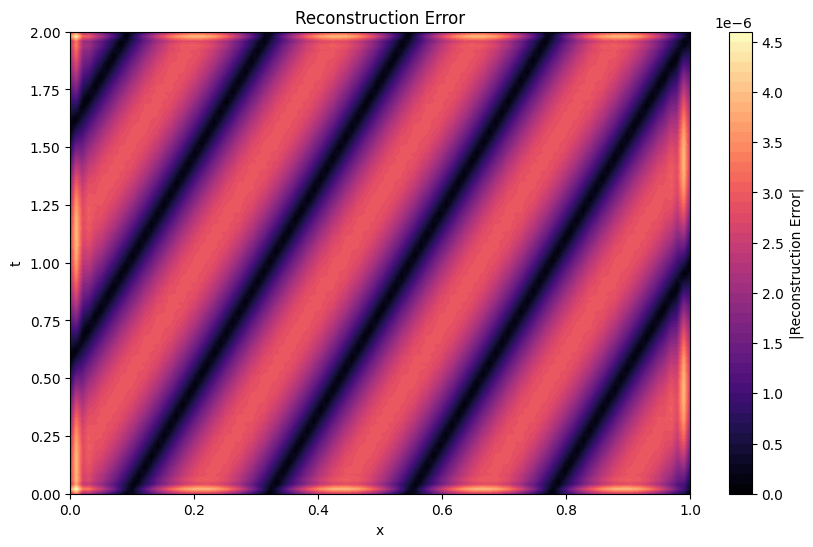

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time


def calculate_control_points(A, B, F, reg=1e-6):
    """
    Solve the 2D least squares problem F ~ A Q B^T with Tikhonov regularization.
    A: (n_t, n_cp_t)    B: (n_x, n_cp_x)     F: (n_t, n_x)
    Q: (n_cp_t, n_cp_x)

    Returns:
    Q_hat of shape (n_cp_t, n_cp_x)
    """
    # Check matrix dimensions
    n_t, n_cp_t = A.shape
    n_x, n_cp_x = B.shape
    if F.shape != (n_t, n_x):
        raise ValueError(f"F must be of shape {(n_t, n_x)}, got {F.shape}.")

    # regularization matrices
    I_t = reg * np.eye(n_cp_t)    # shape (n_cp_t, n_cp_t)
    I_x = reg * np.eye(n_cp_x)    # shape (n_cp_x, n_cp_x)

    # 1. (A^T A + lambda I)^{-1} (A^T F)
    lhs_time = np.linalg.solve(A.T @ A + I_t, A.T @ F)  # shape (n_cp_t, n_x)

    # 2. (B^T B + lambda I)^{-1} B^T
    lhs_space = np.linalg.solve(B.T @ B + I_x, B.T)     # shape (n_cp_x, n_x)

    # 3. Q_hat = lhs_time @ lhs_space^T
    #    lhs_time:   (n_cp_t, n_x)
    #    lhs_space^T (n_x, n_cp_x)
    Q_hat = lhs_time @ lhs_space.T  # shape (n_cp_t, n_cp_x)
    return Q_hat

# ------------------------ MAIN SCRIPT -------------------------------- #



# Load the testing sample
sample_index = 4
sample = training_data[sample_index]

F_true_test = sample['U'].numpy().T  # shape (Nt, Nx)
x = sample['x'].numpy()  # shape (Nx,)
t = sample['t'].numpy()  # shape (Nt,)
X, T = np.meshgrid(x, t)

# Configuration: number of control points / order
n_cp_t = 150
n_cp_x = 150
d = 5

n_t, n_x = F_true_test.shape

start_time = time.time()

# Generate B-spline basis matrices using your functions
tk_t, Ln_t, Bit_t = BsKnots(n_cp_t, d, n_t)  # shape (n_t, n_cp_t)
tk_x, Ln_x, Bit_x = BsKnots(n_cp_x, d, n_x)  # shape (n_x, n_cp_x)

# Convert to numpy arrays if needed
A = np.array(Bit_t)  # (n_t, n_cp_t)
B = np.array(Bit_x)  # (n_x, n_cp_x)
F = F_true_test      # (n_t, n_x)

print(f"A shape: {A.shape}, B shape: {B.shape}, F shape: {F.shape}")

# Solve for Q_hat
Q_hat = calculate_control_points(A, B, F, reg=1e-6)
print("Q_hat shape:", Q_hat.shape)

# Reconstruct the solution: F_reconstructed = A Q_hat B^T
F_reconstructed = A @ Q_hat @ B.T
print("F_reconstructed shape:", F_reconstructed.shape)

# Compute error
reconstruction_error = np.abs(F_reconstructed - F)
mean_error = reconstruction_error.mean()
print(f"Mean Reconstruction Error: {mean_error:.6f}")

end_time = time.time()
print(f"Execution time: {end_time - start_time:.4f} seconds")

# Visualization
plt.figure(figsize=(10, 6))
plt.contourf(X, T, F, levels=50, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.title("Exact Solution")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

plt.figure(figsize=(10, 6))
plt.contourf(X, T, F_reconstructed, levels=50, cmap='viridis',
             vmin=F.min(), vmax=F.max())
plt.colorbar(label='u(x, t)')
plt.title(f"Reconstructed Solution (n_cp_t={n_cp_t}, n_cp_x={n_cp_x}, order={d})")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

plt.figure(figsize=(10, 6))
plt.contourf(X, T, reconstruction_error, levels=50, cmap='magma')
plt.colorbar(label='|Reconstruction Error|')
plt.title("Reconstruction Error")
plt.xlabel("x")
plt.ylabel("t")
plt.show()



BS Net Training

In [ ]:
import time
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ============================================================
# 0) Assumptions
# ============================================================
# You already have these implemented somewhere:
#   BsKnots(n_cp, d, N) -> (tk, Ln, Bit)
#   BsKnots_derivatives(n_cp, d, N, Ln, tk) -> (Bit_derivative, Bit_second_derivative)

# ============================================================
# 1) Model: predict B-spline control points from (beta, phase)
# ============================================================
class BetaPhaseControlPointNet(nn.Module):
    def __init__(self, n_cp_x, n_cp_t, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, n_cp_x * n_cp_t)
        self.n_cp_t = n_cp_t
        self.n_cp_x = n_cp_x

    def forward(self, beta, phase):
        # beta:  (batch,1) ; phase: (batch,1) => concat (batch,2)
        x = torch.cat((beta, phase), dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        out = self.fc3(x)  # (batch, n_cp_t*n_cp_x)
        return out.view(-1, self.n_cp_t, self.n_cp_x)

# ============================================================
# 2) B-spline derivative helper
# ============================================================
def compute_bspline_derivatives(U_full, Bit_t, Bit_x, Bit_t_derivative, Bit_x_derivative):
    # U_full: (n_cp_t, n_cp_x)
    B_surface_t = (Bit_t_derivative @ U_full @ Bit_x.T)
    B_surface_x = (Bit_t @ U_full @ Bit_x_derivative.T)
    return B_surface_t, B_surface_x

# ============================================================
# 3) Overwrite IC row of control points (device-safe)
# ============================================================
def assign_first_row_direct(U_pred, u0_values):
    """
    Overwrite row-0 control points using IC from u0_values (Nx,).
    If n_cp_x != Nx, interpolate.
    U_pred: (n_cp_t, n_cp_x) or (1, n_cp_t, n_cp_x)
    u0_values: numpy array (Nx,)
    """
    if U_pred.ndim == 3:
        row0 = U_pred[0, 0, :]
        n_cp_x = U_pred.shape[2]
    else:
        row0 = U_pred[0, :]
        n_cp_x = U_pred.shape[1]

    Nx = len(u0_values)
    dev = row0.device
    dtype = row0.dtype

    if n_cp_x == Nx:
        row0[:] = torch.as_tensor(u0_values, dtype=dtype, device=dev)
    else:
        x_data = np.arange(Nx)
        x_cp = np.linspace(0, Nx - 1, n_cp_x)
        row0_cp = np.interp(x_cp, x_data, u0_values)  # (n_cp_x,)
        row0[:] = torch.as_tensor(row0_cp, dtype=dtype, device=dev)

# ============================================================
# 4) Metrics + Evaluation
# ============================================================
def rel_l2_error(u_pred, u_true, eps=1e-12):
    # u_pred/u_true: (Nt, Nx)
    num = torch.norm(u_pred - u_true, p=2)
    den = torch.norm(u_true, p=2).clamp_min(eps)
    return num / den

@torch.no_grad()
def evaluate_on_dataset(
    model,
    dataset,
    Bit_t, Bit_x,
    Bit_t_derivative, Bit_x_derivative,
    mse_loss,
    device,
    overwrite_ic=True,
    return_test_mse_terms=False,   # if True: also returns mean test PDE MSE and mean test data MSE
):
    model.eval()

    rel_l2_list = []
    global_max_abs = 0.0  # max over ALL test samples × all t × all x

    test_pde_mse_list = []
    test_data_mse_list = []

    for sample in dataset:
        beta = sample["beta"]
        phase = sample["phases"]
        U_true = sample["U"]

        # Robust conversion (handles numpy or torch)
        if not torch.is_tensor(beta):
            beta = torch.tensor(beta, dtype=torch.float32)
        if not torch.is_tensor(phase):
            phase = torch.tensor(phase, dtype=torch.float32)
        if not torch.is_tensor(U_true):
            U_true = torch.tensor(U_true, dtype=torch.float32)

        beta = beta.to(device)                           # (1,1)
        phase = phase.view(1, -1).to(device)             # (1,1)
        U_true = U_true.to(device)                       # (Nt,Nx)

        U_pred_cp = model(beta, phase)                   # (1,n_cp_t,n_cp_x)

        if overwrite_ic:
            u0_numpy = U_true[0, :].detach().cpu().numpy()
            assign_first_row_direct(U_pred_cp, u0_numpy)

        if U_pred_cp.ndim == 3:
            U_pred_cp = U_pred_cp[0]                     # (n_cp_t,n_cp_x)

        U_pred = (Bit_t @ U_pred_cp @ Bit_x.T)           # (Nt,Nx)

        rel_l2_list.append(rel_l2_error(U_pred, U_true).item())

        sample_max_abs = torch.max(torch.abs(U_pred - U_true)).item()
        global_max_abs = max(global_max_abs, sample_max_abs)

        if return_test_mse_terms:
            # PDE residual: u_t + beta u_x = 0
            U_t, U_x = compute_bspline_derivatives(
                U_pred_cp, Bit_t, Bit_x, Bit_t_derivative, Bit_x_derivative
            )
            pde_res = U_t + beta * U_x
            test_pde_mse_list.append(mse_loss(pde_res, torch.zeros_like(pde_res)).item())
            test_data_mse_list.append(mse_loss(U_pred, U_true).item())

    test_rel_l2_mean = float(np.mean(rel_l2_list))
    test_max_abs_err = float(global_max_abs)

    if return_test_mse_terms:
        return (test_rel_l2_mean, test_max_abs_err,
                float(np.mean(test_pde_mse_list)),
                float(np.mean(test_data_mse_list)))

    return test_rel_l2_mean, test_max_abs_err

# ============================================================
# 5) Main training script
# ============================================================

# -------------------------
# Config
# -------------------------
n_cp_t = 150
n_cp_x = 150
d = 5
hidden_dim = 64
epochs = 2000
lr = 1e-3

w_pde = 10.0
w_data = 10.0

eval_every = 50  # evaluate test metrics every N epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

# -------------------------
# Load data
# -------------------------
with open("advection_training_data.pkl", "rb") as f:
    training_data = pickle.load(f)
with open("advection_testing_data.pkl", "rb") as f:
    testing_data = pickle.load(f)

# -------------------------
# Build B-spline basis (from first training sample)
# -------------------------
# Training samples should contain arrays/tensors for x and t
x0 = training_data[0]["x"]
t0 = training_data[0]["t"]

if torch.is_tensor(x0):
    Nx = int(x0.numel())
else:
    Nx = int(len(x0))

if torch.is_tensor(t0):
    Nt = int(t0.numel())
else:
    Nt = int(len(t0))

tk_x, Ln_x, Bit_x = BsKnots(n_cp_x, d, Nx)
Bit_x_derivative, _ = BsKnots_derivatives(n_cp_x, d, Nx, Ln_x, tk_x)

tk_t, Ln_t, Bit_t = BsKnots(n_cp_t, d, Nt)
Bit_t_derivative, _ = BsKnots_derivatives(n_cp_t, d, Nt, Ln_t, tk_t)

Bit_x = torch.tensor(Bit_x, dtype=torch.float32, device=device)
Bit_t = torch.tensor(Bit_t, dtype=torch.float32, device=device)
Bit_x_derivative = torch.tensor(Bit_x_derivative, dtype=torch.float32, device=device)
Bit_t_derivative = torch.tensor(Bit_t_derivative, dtype=torch.float32, device=device)

# -------------------------
# Model + optimizer
# -------------------------
model = BetaPhaseControlPointNet(n_cp_x, n_cp_t, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse_loss = nn.MSELoss(reduction="mean")

# -------------------------
# Logging
# -------------------------
history = {
    "epoch": [],
    "time_sec": [],
    "train_total": [],
    "train_pde": [],
    "train_data": [],
    "test_rel_l2": [],
    "test_max_abs": [],
}

t_start = time.time()

# -------------------------
# Training loop
# -------------------------
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model.train()

    total_loss = 0.0
    total_pde = 0.0
    total_data = 0.0

    for sample in training_data:
        optimizer.zero_grad()

        beta = sample["beta"]
        phases = sample["phases"]
        U_true = sample["U"]

        # Robust conversion (handles numpy or torch)
        if not torch.is_tensor(beta):
            beta = torch.tensor(beta, dtype=torch.float32)
        if not torch.is_tensor(phases):
            phases = torch.tensor(phases, dtype=torch.float32)
        if not torch.is_tensor(U_true):
            U_true = torch.tensor(U_true, dtype=torch.float32)

        beta = beta.to(device)                         # (1,1)
        phases = phases.view(1, -1).to(device)         # (1,1)
        U_true = U_true.to(device)                     # (Nt,Nx)

        # predict control points
        U_pred_cp = model(beta, phases)                # (1,n_cp_t,n_cp_x)

        # overwrite IC using true u(0,x)
        u0_numpy = U_true[0, :].detach().cpu().numpy()
        assign_first_row_direct(U_pred_cp, u0_numpy)

        if U_pred_cp.ndim == 3:
            U_pred_cp = U_pred_cp[0]                   # (n_cp_t,n_cp_x)

        # reconstruct solution
        U_pred = (Bit_t @ U_pred_cp @ Bit_x.T)         # (Nt,Nx)

        # PDE residual: u_t + beta u_x = 0
        U_t, U_x = compute_bspline_derivatives(
            U_pred_cp, Bit_t, Bit_x, Bit_t_derivative, Bit_x_derivative
        )
        pde_residual = U_t + beta * U_x

        physics_loss = mse_loss(pde_residual, torch.zeros_like(pde_residual))
        data_loss = mse_loss(U_pred, U_true)

        loss = w_pde * physics_loss + w_data * data_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_pde += physics_loss.item()
        total_data += data_loss.item()

    avg_total = total_loss / len(training_data)
    avg_pde = total_pde / len(training_data)
    avg_data = total_data / len(training_data)

    # ---- Evaluate periodically (different times during training) ----
    if (epoch % eval_every == 0) or (epoch == epochs - 1):
        test_rel_l2, test_max_abs = evaluate_on_dataset(
            model,
            testing_data,
            Bit_t, Bit_x,
            Bit_t_derivative, Bit_x_derivative,
            mse_loss,
            device=device,
            overwrite_ic=True,
            return_test_mse_terms=False,
        )

        elapsed = time.time() - t_start

        history["epoch"].append(epoch)
        history["time_sec"].append(elapsed)
        history["train_total"].append(avg_total)
        history["train_pde"].append(avg_pde)
        history["train_data"].append(avg_data)
        history["test_rel_l2"].append(test_rel_l2)
        history["test_max_abs"].append(test_max_abs)

        print(
            f"[epoch {epoch:5d}] "
            f"train_total={avg_total:.3e} "
            f"train_pde={avg_pde:.3e} "
            f"train_data={avg_data:.3e} "
            f"test_relL2={test_rel_l2:.3e} "
            f"test_maxAbs(all)={test_max_abs:.3e} "
            f"time={elapsed:.1f}s"
        )

print("Training complete.")

# -------------------------
# Save
# -------------------------
with open("training_history.pkl", "wb") as f:
    pickle.dump(history, f)
torch.save(model.state_dict(), "trained_model_state_dict.pt")


Training Epochs:   0%|          | 1/2000 [00:00<09:57,  3.35it/s]

[epoch     0] train_total=6.029e+00 train_pde=1.177e-01 train_data=4.852e-01 test_relL2=9.567e-01 test_maxAbs(all)=1.401e+00 time=0.3s


Training Epochs:   3%|▎         | 51/2000 [00:14<09:09,  3.54it/s]

[epoch    50] train_total=1.559e+00 train_pde=4.169e-03 train_data=1.517e-01 test_relL2=5.986e-01 test_maxAbs(all)=1.475e+00 time=14.3s


Training Epochs:   5%|▌         | 101/2000 [00:28<09:01,  3.50it/s]

[epoch   100] train_total=6.222e-01 train_pde=3.102e-03 train_data=5.911e-02 test_relL2=3.757e-01 test_maxAbs(all)=1.263e+00 time=28.3s


Training Epochs:   8%|▊         | 151/2000 [00:42<08:57,  3.44it/s]

[epoch   150] train_total=3.100e-01 train_pde=2.377e-03 train_data=2.862e-02 test_relL2=2.696e-01 test_maxAbs(all)=1.111e+00 time=42.3s


Training Epochs:  10%|█         | 201/2000 [00:56<08:37,  3.47it/s]

[epoch   200] train_total=1.833e-01 train_pde=2.185e-03 train_data=1.614e-02 test_relL2=2.016e-01 test_maxAbs(all)=1.010e+00 time=56.1s


Training Epochs:  13%|█▎        | 251/2000 [01:09<08:09,  3.57it/s]

[epoch   250] train_total=1.377e-01 train_pde=2.004e-03 train_data=1.176e-02 test_relL2=1.825e-01 test_maxAbs(all)=9.553e-01 time=69.8s


Training Epochs:  15%|█▌        | 301/2000 [01:23<07:59,  3.55it/s]

[epoch   300] train_total=1.117e-01 train_pde=1.786e-03 train_data=9.385e-03 test_relL2=1.580e-01 test_maxAbs(all)=8.590e-01 time=83.6s


Training Epochs:  18%|█▊        | 351/2000 [01:37<07:47,  3.53it/s]

[epoch   350] train_total=9.340e-02 train_pde=1.775e-03 train_data=7.564e-03 test_relL2=1.530e-01 test_maxAbs(all)=8.020e-01 time=97.5s


Training Epochs:  20%|██        | 401/2000 [01:51<07:45,  3.44it/s]

[epoch   400] train_total=8.761e-02 train_pde=1.738e-03 train_data=7.023e-03 test_relL2=1.515e-01 test_maxAbs(all)=7.340e-01 time=111.5s


Training Epochs:  23%|██▎       | 451/2000 [02:05<07:25,  3.48it/s]

[epoch   450] train_total=6.795e-02 train_pde=1.527e-03 train_data=5.268e-03 test_relL2=1.479e-01 test_maxAbs(all)=6.763e-01 time=125.4s


Training Epochs:  25%|██▌       | 501/2000 [02:19<07:02,  3.55it/s]

[epoch   500] train_total=6.853e-02 train_pde=1.529e-03 train_data=5.324e-03 test_relL2=1.473e-01 test_maxAbs(all)=6.466e-01 time=139.4s


Training Epochs:  28%|██▊       | 551/2000 [02:33<06:47,  3.55it/s]

[epoch   550] train_total=8.171e-02 train_pde=1.546e-03 train_data=6.626e-03 test_relL2=1.542e-01 test_maxAbs(all)=9.371e-01 time=153.2s


Training Epochs:  30%|███       | 601/2000 [02:47<06:35,  3.54it/s]

[epoch   600] train_total=6.549e-02 train_pde=1.454e-03 train_data=5.095e-03 test_relL2=1.480e-01 test_maxAbs(all)=6.748e-01 time=167.0s


Training Epochs:  33%|███▎      | 651/2000 [03:00<06:29,  3.47it/s]

[epoch   650] train_total=5.697e-02 train_pde=1.379e-03 train_data=4.318e-03 test_relL2=1.581e-01 test_maxAbs(all)=6.584e-01 time=180.9s


Training Epochs:  35%|███▌      | 701/2000 [03:14<06:13,  3.48it/s]

[epoch   700] train_total=6.567e-02 train_pde=1.413e-03 train_data=5.154e-03 test_relL2=1.502e-01 test_maxAbs(all)=6.473e-01 time=194.8s


Training Epochs:  38%|███▊      | 751/2000 [03:28<05:55,  3.51it/s]

[epoch   750] train_total=7.092e-02 train_pde=1.525e-03 train_data=5.566e-03 test_relL2=1.388e-01 test_maxAbs(all)=6.308e-01 time=208.7s


Training Epochs:  40%|████      | 801/2000 [03:42<05:34,  3.58it/s]

[epoch   800] train_total=5.292e-02 train_pde=1.423e-03 train_data=3.869e-03 test_relL2=1.342e-01 test_maxAbs(all)=6.036e-01 time=222.5s


Training Epochs:  43%|████▎     | 851/2000 [03:56<05:26,  3.52it/s]

[epoch   850] train_total=5.422e-02 train_pde=1.480e-03 train_data=3.942e-03 test_relL2=1.390e-01 test_maxAbs(all)=6.843e-01 time=236.3s


Training Epochs:  45%|████▌     | 901/2000 [04:10<05:10,  3.54it/s]

[epoch   900] train_total=4.901e-02 train_pde=1.369e-03 train_data=3.532e-03 test_relL2=1.261e-01 test_maxAbs(all)=6.063e-01 time=250.4s


Training Epochs:  48%|████▊     | 951/2000 [04:24<04:51,  3.60it/s]

[epoch   950] train_total=5.241e-02 train_pde=1.377e-03 train_data=3.863e-03 test_relL2=1.298e-01 test_maxAbs(all)=6.715e-01 time=264.2s


Training Epochs:  50%|█████     | 1001/2000 [04:38<04:48,  3.47it/s]

[epoch  1000] train_total=5.553e-02 train_pde=1.385e-03 train_data=4.168e-03 test_relL2=1.349e-01 test_maxAbs(all)=5.259e-01 time=278.1s


Training Epochs:  53%|█████▎    | 1051/2000 [04:52<04:30,  3.51it/s]

[epoch  1050] train_total=5.378e-02 train_pde=1.400e-03 train_data=3.978e-03 test_relL2=1.347e-01 test_maxAbs(all)=5.430e-01 time=292.1s


Training Epochs:  55%|█████▌    | 1101/2000 [05:06<04:22,  3.43it/s]

[epoch  1100] train_total=4.443e-02 train_pde=1.329e-03 train_data=3.114e-03 test_relL2=1.247e-01 test_maxAbs(all)=5.109e-01 time=306.1s


Training Epochs:  58%|█████▊    | 1151/2000 [05:20<04:07,  3.43it/s]

[epoch  1150] train_total=4.571e-02 train_pde=1.371e-03 train_data=3.200e-03 test_relL2=1.275e-01 test_maxAbs(all)=5.716e-01 time=320.3s


Training Epochs:  60%|██████    | 1201/2000 [05:34<03:45,  3.54it/s]

[epoch  1200] train_total=4.425e-02 train_pde=1.358e-03 train_data=3.067e-03 test_relL2=1.279e-01 test_maxAbs(all)=6.152e-01 time=334.3s


Training Epochs:  63%|██████▎   | 1251/2000 [05:48<03:34,  3.50it/s]

[epoch  1250] train_total=3.826e-02 train_pde=1.362e-03 train_data=2.464e-03 test_relL2=1.204e-01 test_maxAbs(all)=5.239e-01 time=348.1s


Training Epochs:  65%|██████▌   | 1301/2000 [06:01<03:14,  3.59it/s]

[epoch  1300] train_total=4.155e-02 train_pde=1.431e-03 train_data=2.724e-03 test_relL2=1.258e-01 test_maxAbs(all)=6.304e-01 time=361.9s


Training Epochs:  68%|██████▊   | 1351/2000 [06:15<03:09,  3.43it/s]

[epoch  1350] train_total=4.299e-02 train_pde=1.428e-03 train_data=2.871e-03 test_relL2=1.218e-01 test_maxAbs(all)=5.603e-01 time=375.8s


Training Epochs:  70%|███████   | 1401/2000 [06:29<02:52,  3.48it/s]

[epoch  1400] train_total=4.322e-02 train_pde=1.406e-03 train_data=2.916e-03 test_relL2=1.264e-01 test_maxAbs(all)=5.643e-01 time=389.7s


Training Epochs:  73%|███████▎  | 1451/2000 [06:43<02:35,  3.52it/s]

[epoch  1450] train_total=3.937e-02 train_pde=1.422e-03 train_data=2.514e-03 test_relL2=1.125e-01 test_maxAbs(all)=5.207e-01 time=403.6s


Training Epochs:  75%|███████▌  | 1501/2000 [06:57<02:20,  3.54it/s]

[epoch  1500] train_total=3.593e-02 train_pde=1.344e-03 train_data=2.249e-03 test_relL2=1.203e-01 test_maxAbs(all)=5.563e-01 time=417.5s


Training Epochs:  78%|███████▊  | 1551/2000 [07:11<02:06,  3.55it/s]

[epoch  1550] train_total=5.728e-02 train_pde=1.477e-03 train_data=4.251e-03 test_relL2=1.261e-01 test_maxAbs(all)=5.152e-01 time=431.4s


Training Epochs:  80%|████████  | 1601/2000 [07:25<01:58,  3.36it/s]

[epoch  1600] train_total=4.244e-02 train_pde=1.293e-03 train_data=2.951e-03 test_relL2=1.088e-01 test_maxAbs(all)=5.529e-01 time=445.2s


Training Epochs:  83%|████████▎ | 1651/2000 [07:39<01:38,  3.56it/s]

[epoch  1650] train_total=4.186e-02 train_pde=1.355e-03 train_data=2.831e-03 test_relL2=1.119e-01 test_maxAbs(all)=4.896e-01 time=459.1s


Training Epochs:  85%|████████▌ | 1701/2000 [07:52<01:23,  3.56it/s]

[epoch  1700] train_total=3.215e-02 train_pde=1.334e-03 train_data=1.881e-03 test_relL2=1.042e-01 test_maxAbs(all)=4.923e-01 time=472.9s


Training Epochs:  88%|████████▊ | 1751/2000 [08:06<01:10,  3.53it/s]

[epoch  1750] train_total=3.820e-02 train_pde=1.283e-03 train_data=2.537e-03 test_relL2=1.093e-01 test_maxAbs(all)=4.423e-01 time=486.8s


Training Epochs:  90%|█████████ | 1801/2000 [08:20<00:57,  3.44it/s]

[epoch  1800] train_total=5.119e-02 train_pde=1.397e-03 train_data=3.722e-03 test_relL2=1.164e-01 test_maxAbs(all)=6.602e-01 time=500.7s


Training Epochs:  93%|█████████▎| 1851/2000 [08:34<00:42,  3.51it/s]

[epoch  1850] train_total=3.714e-02 train_pde=1.419e-03 train_data=2.295e-03 test_relL2=9.897e-02 test_maxAbs(all)=5.078e-01 time=514.6s


Training Epochs:  95%|█████████▌| 1901/2000 [08:48<00:27,  3.61it/s]

[epoch  1900] train_total=3.148e-02 train_pde=1.308e-03 train_data=1.841e-03 test_relL2=9.804e-02 test_maxAbs(all)=6.786e-01 time=528.6s


Training Epochs:  98%|█████████▊| 1951/2000 [09:02<00:13,  3.56it/s]

[epoch  1950] train_total=3.393e-02 train_pde=1.331e-03 train_data=2.063e-03 test_relL2=1.045e-01 test_maxAbs(all)=6.297e-01 time=542.4s


Training Epochs: 100%|██████████| 2000/2000 [09:16<00:00,  3.60it/s]

[epoch  1999] train_total=3.603e-02 train_pde=1.256e-03 train_data=2.347e-03 test_relL2=1.046e-01 test_maxAbs(all)=5.122e-01 time=556.1s
Training complete.


Visualizations

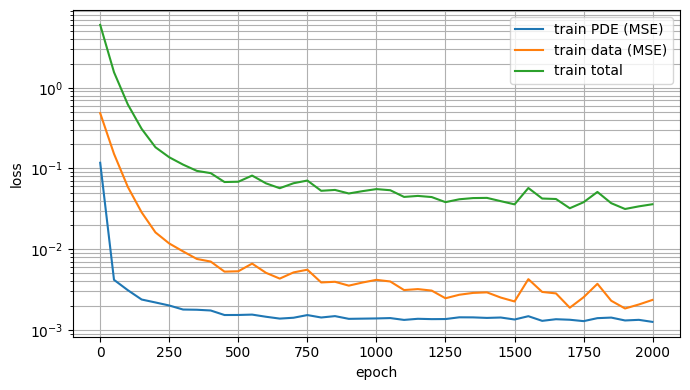

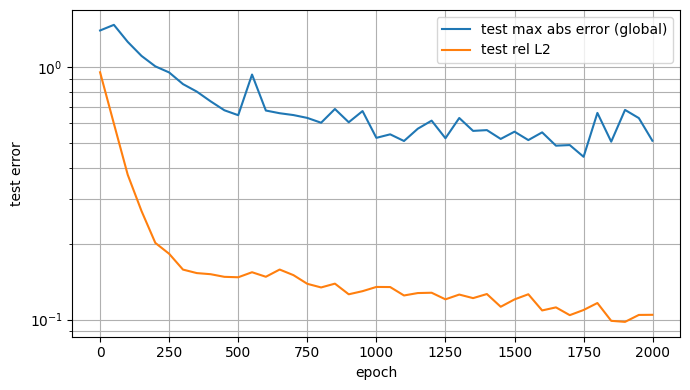

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.array(history["epoch"])
train_pde  = np.array(history["train_pde"])
train_data = np.array(history["train_data"])
train_total = np.array(history["train_total"])
test_max = np.array(history["test_max_abs"])
test_rel = np.array(history["test_rel_l2"])

plt.figure(figsize=(7,4))
plt.plot(epochs, train_pde, label="train PDE (MSE)")
plt.plot(epochs, train_data, label="train data (MSE)")
plt.plot(epochs, train_total, label="train total")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, test_max, label="test max abs error (global)")
plt.plot(epochs, test_rel, label="test rel L2")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("test error")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()


log–log slope α ≈ 0.343


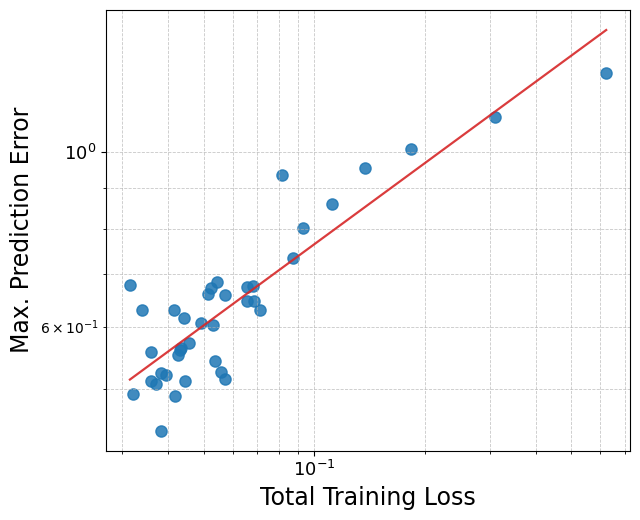

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Extract arrays
# ----------------------------
train_total = np.array(history["train_total"], dtype=float)
test_maxabs = np.array(history["test_max_abs"], dtype=float)

x = train_total          # ← total training loss
y = test_maxabs          # ← global max abs error

# ----------------------------
# Filter: total loss <= 1
# ----------------------------
cutoff = 1.0
mask = (x > 0) & (y > 0) & np.isfinite(x) & np.isfinite(y) & (x <= cutoff)

x_f = x[mask]
y_f = y[mask]

# ----------------------------
# Log–log regression
# ----------------------------
def fit_loglog(xv, yv, eps=1e-30):
    lx = np.log(xv + eps)
    ly = np.log(yv + eps)
    alpha, b = np.polyfit(lx, ly, 1)
    return alpha, b

alpha, b = fit_loglog(x_f, y_f)
print(f"log–log slope α ≈ {alpha:.3f}")

x_fit = np.logspace(np.log10(x_f.min()), np.log10(x_f.max()), 200)
y_fit = np.exp(b) * x_fit**alpha

# ----------------------------
# Plot (clean, paper-ready)
# ----------------------------
plt.figure(figsize=(6.5, 5.3))

plt.scatter(
    x_f, y_f,
    s=65,
    alpha=0.85
)

plt.plot(
    x_fit, y_fit,
    linewidth=1.6,
    color="tab:red",
    alpha=0.9
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Total Training Loss", fontsize=17)
plt.ylabel("Max. Prediction Error", fontsize=17)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.savefig("scaling_testmax_vs_train_total_filtered.pdf", dpi=300)
plt.show()
